# SMP 가격 예측모델
본 글은 루트에너지 투자설명서에 들어갈, SMP가격에 대한 장기예측에 대한 설명서이다. 태양광 발전소 예측에 필요한 20년의 SMP가격에 대해서 예측을 할예정이다. 

## 변수의 선정(Variable Selection)
신동현,김재혁의 [전력 발전시장의 충격식별과 계통한계가격 변동성 분석]("https://www.kci.go.kr/kciportal/ci/sereArticleSearch/ciSereArtiView.kci?sereArticleSearchBean.artiId=ART002035364")에서는 SMP가격에 영향을 미치는 5개의 변수의 관계와 가격변동성을 분석을 했다. 논문에서는 5개의 변수의 연관이 있다고 판단을 하였다.  

|        | 설명 | 차분|
|:------:|:------:|:------:|
|SMP 가격 | 예비율이 낮으면, 가격이 높은 발전소까지 가동되며 SMP가 올라간다. |로그 차분|
|공급예비율 |발전소가 얼만큼 남았는지 나타내는 변수이다.|로그 차분|
|SMP 연료별 결정요인 |석유발전소에서 SMP가 결정되는지, LNG발전소에서 결정되는지? 첨두부하의 비중  |로그 차분|
|연료원별 단가 | LNG 및 유가 |로그 차분|
|예측오차 |예측이 실패할수록 계통제약 정산금이 발생하여서 SMP 단가가 상승한다.  |로그 차분|

장기예측임을 감안해서 예측오차를 제외하겠고, 전력데이터는 [EPSIS]("http://epsis.kpx.or.kr/epsisnew/")를 참고하겠다.우선 데이터 전처리를 해보겠다. 

In [153]:
import os 
import pandas as pd 
os.chdir("/Users/youngji/Google 드라이브/data")

smp_month1=pd.read_excel("smp_data_month.xls",skiprows=1,sheetname='Sheet1') ##EPSIS 참조
smp_month2=smp_month1.sort_index(axis=0, ascending=False)
smp_month3=smp_month2.rename(columns={'Unnamed: 0':'기간','통합':'smp'})
smp_month4=smp_month3.sort_values(by="기간")
smp_month5=smp_month4.set_index(keys=pd.period_range(start='2001-04',periods=smp_month4.shape[0],freq='M'))
smp_month6=smp_month5.loc[:,['smp']]

oil_price1=pd.read_excel("oil_price.xls",skiprows=2,sheetname='Data 1')
oil_price2=oil_price1.set_index(keys=pd.period_range(start='1986-07',periods=oil_price1.shape[0],freq='M'))
oil_price3=oil_price2.rename(columns={'Cushing, OK WTI Spot Price FOB (Dollars per Barrel)':'유가',}).유가

elec_supply1=pd.read_excel("supply_month.xls",sheetname='Sheet1')
elec_supply2=elec_supply1[(elec_supply1.loc[:,'년']!=2004) | (elec_supply1.loc[:,'월']!=12)| (elec_supply1.loc[:,'일']!=23)]
elec_supply3=elec_supply2.sort_index(axis=0,ascending=False)
elec_supply4=elec_supply3.set_index(keys=pd.period_range(start='2003-01',periods=elec_supply2.shape[0],freq='M'))
elec_supply5=elec_supply4.loc[:,['공급예비율(%)']]
elec_supply6=elec_supply5.rename(columns={'공급예비율(%)':'공급예비율'})

smp_determination1=pd.read_excel("smp_determination.xls",sheetname='Sheet1')
smp_determination2=smp_determination1.sort_index(axis=0,ascending=False)
smp_determination3=smp_determination2.set_index(keys=pd.period_range(start='2001-04',periods=smp_determination2.shape[0],freq='M'))
smp_determination3.LNG=smp_determination3.LNG/smp_determination3.총계*100;smp_determination3.유류=smp_determination3.유류/smp_determination3.총계*100
df=pd.Series(smp_determination3.LNG+smp_determination3.유류)
smp_determination4=pd.concat(objs=[smp_determination3,df],axis=1);smp_determination4
smp_determination5=smp_determination4.loc[:,('LNG','유류',0)]
smp_determination6=smp_determination5.rename(columns={'유류':'유류결정','LNG':'LNG비중',0:'첨두비중'})

연료원은 LNG가격와 유가가 고려되지만, 둘간의 상관관계가 매우 크기 때문에 선행변수로 유가만 고려하겠다. 또한, SMP가격(원/kwh)은 한국은행기준 생산성물가지수로, 유가($/Barrel)는 미국 노동부의 생산자물가지수로 조정했다. 

In [154]:
producer_Korea1=pd.read_excel("producer_price_Korea.xlsx",sheetname='월간지수')
producer_Korea2=producer_Korea1.set_index(keys=pd.period_range(start='2001-04',periods=producer_Korea1.shape[0],freq='M'))
producer_US1=pd.read_excel("producer_price_US.xlsx",sheetname='월간지수')
producer_US2=producer_US1.set_index(keys=pd.period_range(start='2001-04',periods=producer_US1.shape[0],freq='M'))

elec_data1=pd.concat(objs=[smp_month6,oil_price3,elec_supply6,smp_determination6,producer_Korea2,producer_US2],axis=1)
elec_data2=elec_data1.loc['2003-01':'2015-12']
elec_data2.smp=elec_data2.smp*elec_data1.한국_생산자물가
elec_data2.유가=elec_data2.유가*elec_data1.미국_생산자물가

/Users/youngji/anaconda/lib/python3.6/site-packages/pandas/core/generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


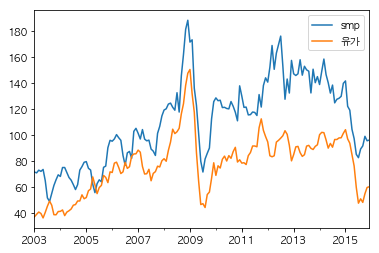

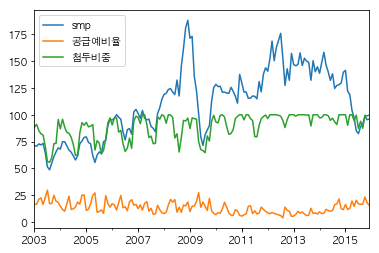

In [155]:
import matplotlib
import matplotlib.pyplot as plt 
matplotlib.rc('font', family="AppleGothic") 
elec_data2.loc[:,["smp","유가"]].plot()
elec_data2.loc[:,["smp","공급예비율","첨두비중"]].plot()
plt.show()

## 변수의 검정(Variable Verification)

현재 그래프 상의 유가/LNG가격과 SMP가격 사이에는 상관관계가 있어보이고, 공급예비율과 SMP 결정횟수(첨두비중)과 SMP가격간의 관계는 그래프상 잘 들어나지 않는다. 회귀분석을 해보겠다. 우선 첨두비중/공급예비율과 SMP가격간의 상관관계를 살펴보고 나머지 변수들을 살펴보겠다. 전통적인 회귀분석은 아래의 4가지 가정을 만족시켜야 한다. 
- 정규성:종속변수가 정규분포를 이뤄야 하며,그렇다면 잔차(residual)들도 정규분포를 이루어야 한다. 통상적으로 QQ-plot을 통해서 검정을 한다. 
- 독립성:종속변수들간에는 상호간에 영향을 미치지 않아야 한다. 예를들어, 유가와 LNG는 밀접한 연관있어서 동시에 사용하면, VIF(Variance Inflation Factor)검정을 통해서 확인한다. 
- 선형성: 종속변수와 독립변수가 선형관계에 있다면 잔차와 예측치 사이에 어떤 체계적인 관계가 있으면 안 된다.
- 동분산성: 변수들간의 분산이 같아야 한다. 

본 예측치는 "smp~ 유류+공급예비율"모델로 우선적으로 검정을 해보겠다. 장기예측시 시나리오가 필요한데, 현재 LNG가격과 첨두비중의 장기예측 데이터 확보에 다소 어려움이 있다. 우선 모델 검정값은 아래와 같다. 

$$ SMP가격 = 49.5+ 1.06*유가(WTI기준,6개월 전 데이터)-1.57*공급예비율 $$ 

모델검정값을 세부적으로 살펴보면,
- 계수의 표준편차는 작아서 사용가능한 모델이라고 판단한다. 공급예비율의 P-Value가 5.1%로 통상적인  P-value한계값은 넘어가지만, 5%의 기준도 절대적이지는 않다고 판단한다. 
- $R^2$값(결정계수)이 0.7이고, 수정된$R^2$도 $R^2$가 큰 차이나지 않는 것은 변수들간의 VI(Variance Influetion)이크지 않다는 반증이기도 하다. 때문에 충분히 설명력이 있는 모델이라고 판단한다.추가적인 다중공선성(Multilinearity) 검정은 생략하겠다. 
- F-statisics의 P-value도 0.05 보다 작아서 설명력이 있다고 판단한다. 

In [159]:
import statsmodels.formula.api as smf
model=smf.ols(formula = 'smp ~ 유가+공급예비율', data = elec_data2).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    smp   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                     282.8
Date:                Tue, 13 Jun 2017   Prob (F-statistic):           4.01e-52
Time:                        18:19:01   Log-Likelihood:                -642.67
No. Observations:                 156   AIC:                             1291.
Df Residuals:                     153   BIC:                             1300.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     49.5078      6.396      7.741      0.0

다소 우려가 되는 점은, 잔차의 정규성이 충분하지 않다는 점이다. 
- QQ-pplot이 정확히 직선이 아님. 
- Durbin-Watson검정값이 지나치게 낮다는 것이다.(통상적으로 1~3사이어야함)
위 사항은 추가적인 통계방법으로 보완하겠다. 

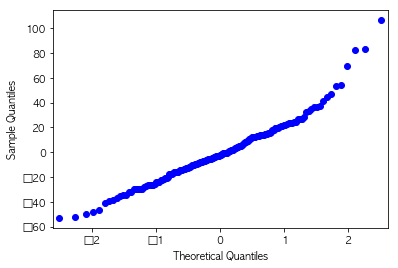

In [44]:
import statsmodels.api as sm
res = model.resid # residuals
fig = sm.qqplot(res)
plt.show()

## 예측(Prediction)
본 보고서의 유가 

- WEO 유가예측: 3개 시나리오로 10년 단위  
- 7차 전력수급기본계획의 공급예비율 전망 

WEO유가 시나리오 분석에서는 아래와 같은 시나리오를 제시한다.

|        | New Policies Scenario| Current Policies Scenario| 450 Scenario|
|:------:|:------:|:------:|:------:|
|2015(기준)|51|51|51|
|2020|79|82|73|
|2030|111|127|85|
|2040|124|146|73|

WEO분석의 가장 큰 무넺는 10년단위 거시적인 데이터만 제공하기 때문에 월단위 데이터는 추정을 해야 한다는 점이다. 

In [157]:
WEO_scenario=pd.DataFrame({'WEO_NP1':pd.Series(index=pd.period_range(start='2015-01',periods=12*25,freq='M')),
                           'WEO_CP1':pd.Series(index=pd.period_range(start='2015-01',periods=12*25,freq='M')),
                           'WEO_4501': pd.Series(index=pd.period_range(start='2015-01',periods=12*25,freq='M'))})
WEO_period=[pd.Period('2015-01'),pd.Period('2020-01'),pd.Period('2030-01'),pd.Period('2040-01')]
WEO_data=pd.DataFrame({'WEO_NP':pd.Series([51,79,111,124],index=WEO_period),
                       'WEO_CP':pd.Series([51,82,127,146],index=WEO_period),
                       'WEO_450':pd.Series([51,73,85,73],index=WEO_period)})
WEO1=pd.concat(objs=[WEO_scenario,WEO_data],axis=1).loc[:,['WEO_NP','WEO_CP','WEO_450']]
WEO1.loc['2017-06']=[48.36,48.36,48.36] ## 17년 6월 1일 기준 현재 유가 입력 
WEO2=WEO1.interpolate()
## 공급예비율 계산 
supply_plan1=pd.read_excel("supply_plan.xlsx",skiprows=0,sheetname='시트 1')
supply_period=[pd.Period('2015-01'),pd.Period('2016-01'),pd.Period('2017-01'),pd.Period('2018-01'),pd.Period('2019-01'),
               pd.Period('2020-01'),pd.Period('2021-01'),pd.Period('2022-01'),pd.Period('2023-01'),pd.Period('2024-01'),
               pd.Period('2025-01'),pd.Period('2026-01'),pd.Period('2027-01'),pd.Period('2028-01'),pd.Period('2029-01'),
               pd.Period('2030-01'),pd.Period('2031-01'),pd.Period('2032-01'),pd.Period('2033-01'),pd.Period('2034-01'),
               pd.Period('2035-01'),pd.Period('2036-01'),pd.Period('2037-01'),pd.Period('2038-01'),pd.Period('2039-01'),    
               pd.Period('2040-01')]
supply_plan2=supply_plan1.set_index(keys=[supply_period])
supply_plan3=supply_plan2.공급예비율
supply_scenario=pd.Series(index=pd.period_range(start='2015-01',periods=12*25,freq='M'))
supply1=pd.concat(objs=[supply_plan3,supply_scenario],axis=1).공급예비율
supply2=supply1.interpolate()
## 데이터를 합친다.
fuel_supply1=pd.concat(objs=[WEO2,supply2],axis=1)
fuel_supply2=fuel_supply1.loc['2017-06':'2037-12']

이제 본격적인 예측을 하면된다. 

In [177]:
x=model.predict(fuel_supply2.rename(columns={'WEO_NP':'유가'}))
y=model.predict(fuel_supply2.rename(columns={'WEO_CP':'유가'}))
z=model.predict(fuel_supply2.rename(columns={'WEO_450':'유가'}))

pred=pd.DataFrame({'SMP예측(NP)':x,'SMP예측(CP)':y,'SMP예측(450)':z},
                  index=pd.period_range(start='2017-06',end='2037-12',freq='M'))
final_data=pd.concat(objs=[fuel_supply2,pred],axis=1)


In [180]:
writer = pd.ExcelWriter('SMP예측.xlsx')
final_data.to_excel(writer,'SMP예측')
writer.save()